In [ ]:
# https://dev.to/afrozchakure/hyper-parameter-tuning-to-optimize-ml-models-mobilenet-v2-4jnc
# https://datascience.stackexchange.com/questions/46523/is-a-large-number-of-epochs-good-or-bad-idea-in-cnn
# https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
# https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset -f

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preparation

In [ ]:
train_data_dir = "/content/drive/MyDrive/PersonalProjects/CXR/bp3/train"
val_data_dir = "/content/drive/MyDrive/PersonalProjects/CXR/bp3/test"

class_subset = sorted(f for f in os.listdir(train_data_dir) if not f.startswith('.'))
print(class_subset)

['negative', 'positive']


In [ ]:
#central crop
def crop_center_square(image):
    img_height, img_width = image.shape[0:2]
    min_dim = min(img_height, img_width)
    start_x = (img_width // 2) - (min_dim // 2)
    start_y = (img_height // 2) - (min_dim // 2)
    
    img = image[start_y : start_y + min_dim, start_x : start_x + min_dim]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

# Definte Image Data Generator

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255.,
                                     featurewise_center= False,
                                     samplewise_center= False,
                                     featurewise_std_normalization= False,
                                     samplewise_std_normalization=False,
                                     rotation_range= 10,     # 0-180
                                     zca_whitening=False,
                                     zoom_range=0.1,         # Randomly zoom image
                                     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                     height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                                     horizontal_flip=True,   # randomly flip images
                                     vertical_flip=False,
                                     validation_split=0.0,
                                     preprocessing_function=crop_center_square)

val_generator  = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=crop_center_square)

# Define Models

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

BATCH_SIZE = 8
image_size = 224
channel = 3
lr = 1e-4

## MobileNetV2 

In [ ]:
# MobileNetV2
mobilenet_base_model = MobileNetV2(weights='imagenet',
                                   include_top= False, 
                                   input_shape=(image_size, image_size, channel),
                                   pooling='avg')

mobilenet_base_model.trainable = False

mobilenet_model = Sequential()
mobilenet_model.add(mobilenet_base_model)
mobilenet_model.add(layers.Dense(256,activation='relu'))
mobilenet_model.add(layers.Dropout(0.2))
mobilenet_model.add(layers.Dense(len(class_subset),activation="softmax"))

mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate = lr), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


## Define data generators

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(image_size, image_size),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=21)

validgen = val_generator.flow_from_directory(val_data_dir,
                                             target_size=(image_size, image_size),
                                             classes=class_subset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             seed=21)


Found 676 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [ ]:
model_dict = {
    "mobilenetv2": mobilenet_model
}

weightfile_dict = {
    "mobilenetv2" : 'mobilenetv2_model.hdf5'
}

historyfile_dict = {
    "mobilenetv2" : 'mobilenetv2_history.csv'
}

In [ ]:
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

# Modeling Training & Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
n_epochs = 50

# Callback Function: EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')

# Callback Function: Reduce learning rate on plateau
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

for key in model_dict:
    print ("Training {} ".format(key.upper()))
    print ("")

    model = model_dict[key]

    best_checkpoint = ModelCheckpoint(weightfile_dict[key],
                                      save_weights_only=False, 
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

    history_logger = CSVLogger(historyfile_dict[key], separator=",", append=True)

    history = model.fit(traingen,
                        batch_size=BATCH_SIZE,
                        epochs=n_epochs,
                        validation_data=validgen,
                        steps_per_epoch=traingen.samples // BATCH_SIZE,
                        validation_steps=validgen.samples // BATCH_SIZE,
                        callbacks=[best_checkpoint, history_logger, early_stop], #red_lr
                        verbose=1)

Training MOBILENETV2 

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8024
Epoch 1: val_accuracy improved from -inf to 0.75735, saving model to mobilenetv2_model.hdf5
84/84 [==============================] - 174s 2s/step - loss: 0.4534 - accuracy: 0.8024 - val_loss: 0.4982 - val_accuracy: 0.7574
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8802
Epoch 2: val_accuracy improved from 0.75735 to 0.77941, saving model to mobilenetv2_model.hdf5
84/84 [==============================] - 28s 340ms/step - loss: 0.3014 - accuracy: 0.8802 - val_loss: 0.4665 - val_accuracy: 0.7794
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8862
Epoch 3: val_accuracy did not improve from 0.77941
84/84 [==============================] - 28s 335ms/step - loss: 0.2621 - accuracy: 0.8862 - val_loss: 0.6778 - val_accuracy: 0.7402
Epoch 4/50
84/84 [==============================] - ETA: 0s - l

# Plot Graphs

In [ ]:
import seaborn as sns
sns.set_theme()

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

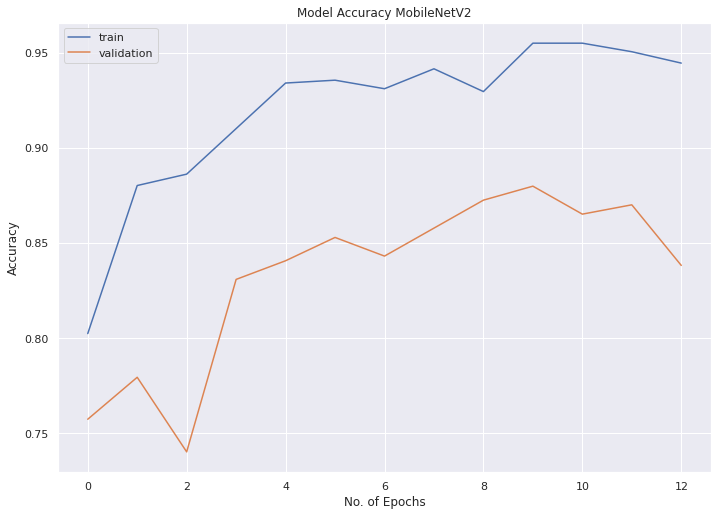

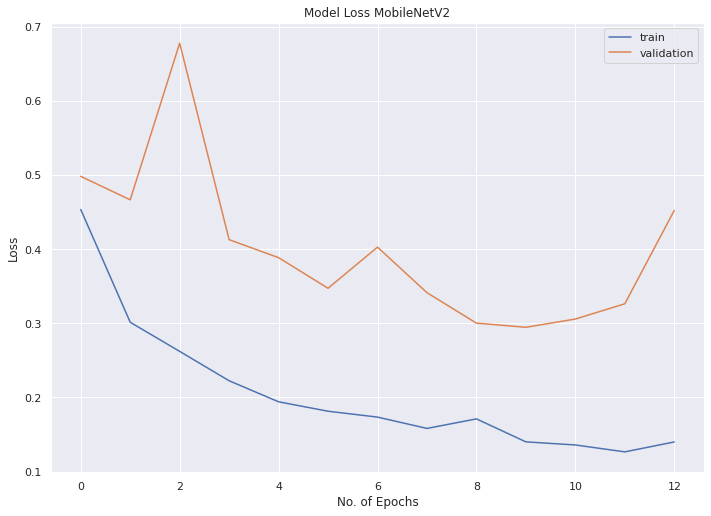

In [ ]:
history = pd.read_csv("mobilenetv2_history.csv")

plt.plot(history['epoch'], history['accuracy'])
plt.plot(history['epoch'], history['val_accuracy'])
plt.title('Model Accuracy MobileNetV2')
plt.legend(['train', 'validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(history['epoch'], history['loss'])
plt.plot(history['epoch'], history['val_loss'])
plt.title('Model Loss MobileNetV2')
plt.legend(['train', 'validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.show()